### Using NFStream to process all the PCAP files to have flow records, set high timeouts to not expire the flows by any of them

In [1]:
import nfstream
import os
from nfstream import NFPlugin
import csv

def process_pcap_NF(pcap_directory: str):
    
    pcap_files = [f for f in os.listdir(pcap_directory) if f.endswith('.pcap')]
    print(f"Found {len(pcap_files)} .pcap files. Processing...")

    for filename in pcap_files:
        path = os.path.join(pcap_directory, filename)

        streamer = nfstream.NFStreamer(source=path,
                                       statistical_analysis=True,
                                       splt_analysis=255,
                                       idle_timeout=99999999999999,
                                       active_timeout=99999999999999,
                                       accounting_mode=2,
                                       udps=None,
                                       n_dissections=20,
                                       n_meters=1,
        )

        os.makedirs("VNAT/CF", exist_ok=True)
        output_folder = os.path.join(os.path.dirname(path), "CF")

        output_csv = os.path.join(output_folder, os.path.splitext(os.path.basename(path))[0] + ".csv")

        streamer.to_csv(output_csv)


if __name__ == '__main__':
    pcap_directory =  "VNAT"

    print(f"Starting NFStream v{nfstream.__version__}")
    
    process_pcap_NF(pcap_directory)

    print("All files processed.")

Starting NFStream v6.5.4b
Found 165 .pcap files. Processing...
All files processed.


### Merge the CSV files into one large CSV

In [2]:
import os
import pandas as pd

directory = "VNAT/CF"

dataframes = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):  
        df = pd.read_csv(os.path.join(directory, filename),low_memory=False)
        
        if 'nonvpn' in filename.lower():
            df['label'] = 'NoVPN'
        else:    
            df['label'] = 'VPN'
        df['source_file']=filename
        dataframes.append(df)

df_large = pd.concat(dataframes, ignore_index=True)

df_large.to_csv("VNAT/CF/flows_CF.csv", index=False)

### Read the large CSV in and assign categories based on the source file names

In [3]:
import pandas as pd

df = pd.read_csv("VNAT/CF/flows_CF.csv")


category_mapping = {
    'skype': 'Chat',
    'vimeo': 'Streaming',
    'netflix': 'Streaming',
    'youtube': 'Streaming',
    'ssh': 'Command & Control',
    'rdp': 'Command & Control',
    'sftp': 'File Transfer',
    'rsync': 'File Transfer',
    'scp': 'File Transfer',
    'voip': 'VoIP'
}

def assign_category(source_file):
    for keyword, category in category_mapping.items():
        if keyword in source_file.lower():
            return category
    return 'Unknown'  

df['category'] = df['source_file'].apply(assign_category)

df['category'].value_counts()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/var/folders/26/m1ty4dhn4kd02qvztlq5pdlh0000gp/T/ipykernel_60072/3332365726.py:3: DtypeWarning: Columns (87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("VNAT/CF/flows.csv")


category
File Transfer        16430
Command & Control    13599
Streaming             1764
Chat                  1301
VoIP                   617
Name: count, dtype: int64

In [6]:
df.to_csv('VNAT/CF/flows_extra_labelled_CF.csv', index=False)

###  CDF to see how the samples distribute across flow duration and packet count

/var/folders/26/m1ty4dhn4kd02qvztlq5pdlh0000gp/T/ipykernel_60072/276095087.py:7: DtypeWarning: Columns (87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_df = pd.read_csv('VNAT/CF/flows_extra_labelled.csv')


Number of rows before filtering: 33711
Number of rows after filtering: 33711
CDF at 41.0 seconds: 0.9180089585001928


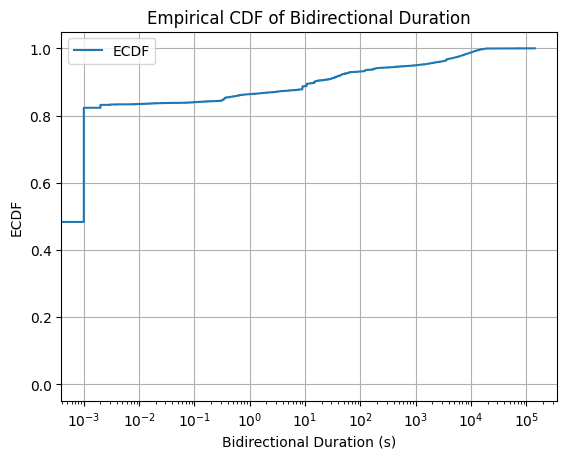

CDF at 8000 packets: 0.994185874047047


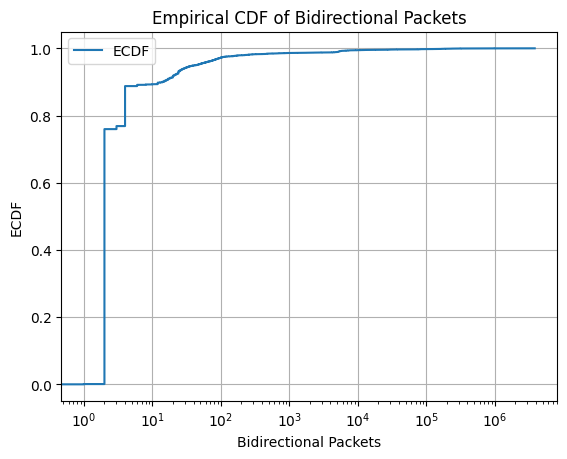

16292


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Load dataset
filtered_df = pd.read_csv('VNAT/CF/flows_extra_labelled_CF.csv')
print(f"Number of rows before filtering: {df.shape[0]}")


print(f"Number of rows after filtering: {filtered_df.shape[0]}")
data_duration = filtered_df['bidirectional_duration_ms'].dropna() / 1000  

ecdf_duration = ECDF(data_duration)

value_duration = 41.0  
print(f"CDF at {value_duration} seconds: {ecdf_duration(value_duration)}")

plt.step(ecdf_duration.x, ecdf_duration.y, label="ECDF")
plt.xscale('log') 
plt.xlabel('Bidirectional Duration (s)')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Bidirectional Duration')
plt.legend()
plt.grid(True)
plt.show()

###################################################################

data_packets = filtered_df['bidirectional_packets'].dropna() 

ecdf_packets = ECDF(data_packets)

value_packets = 8000  
print(f"CDF at {value_packets} packets: {ecdf_packets(value_packets)}")

plt.step(ecdf_packets.x, ecdf_packets.y, label="ECDF")
plt.xscale('log') 
plt.xlabel('Bidirectional Packets')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Bidirectional Packets')
plt.legend()
plt.grid(True)
plt.show()


print(filtered_df['bidirectional_duration_ms'].value_counts().max())

In [8]:
data_duration.describe()

count     33711.000000
mean        379.621809
std        2480.214632
min           0.000000
25%           0.000000
50%           0.001000
75%           0.001000
max      142910.250000
Name: bidirectional_duration_ms, dtype: float64

In [9]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(data_packets.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

count     33711.00
mean       1130.29
std       37416.79
min           1.00
10%           2.00
25%           2.00
50%           2.00
75%           2.00
80%           4.00
85%           4.00
90%          14.00
91%          18.00
92%          21.00
93%          24.00
94%          29.00
95%          44.00
96%          65.00
97%          93.00
98%         228.00
99%        5250.00
max     3842411.00
Name: bidirectional_packets, dtype: float64


### CDF with filter out any flows that have less than 20 packets

Number of rows before filtering: 33711
Number of rows after filtering: 2923
CDF at 41.0 seconds: 0.6387273349298666


/var/folders/26/m1ty4dhn4kd02qvztlq5pdlh0000gp/T/ipykernel_60072/3264661265.py:7: DtypeWarning: Columns (87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_df = pd.read_csv('VNAT/CF/flows_extra_labelled.csv')


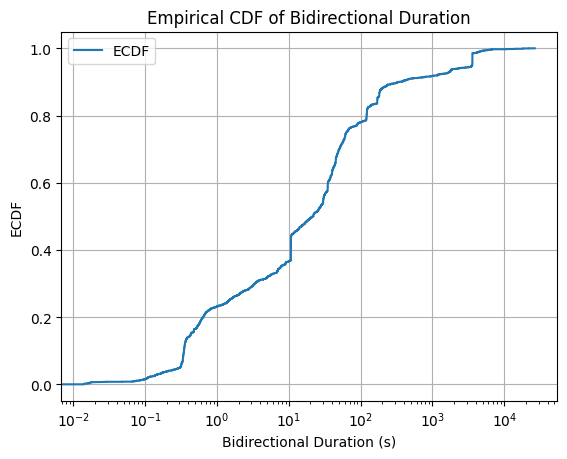

CDF at 8000 packets: 0.9329456038316798


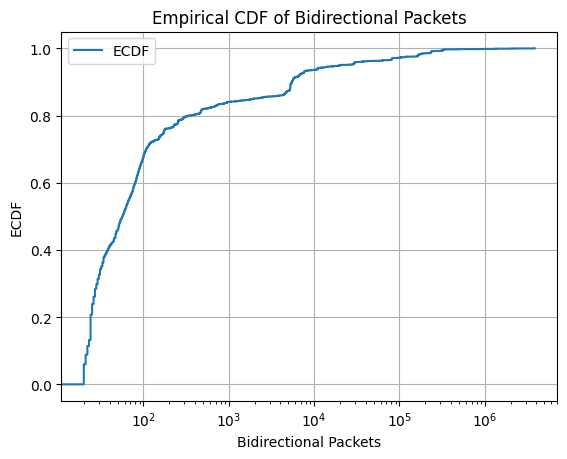

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

filtered_df = pd.read_csv('VNAT/CF/flows_extra_labelled_CF.csv')
print(f"Number of rows before filtering: {df.shape[0]}")

filtered_df = filtered_df[filtered_df['bidirectional_packets'] > 19]

print(f"Number of rows after filtering: {filtered_df.shape[0]}")

data_duration = filtered_df['bidirectional_duration_ms'].dropna() / 1000  

ecdf_duration = ECDF(data_duration)

value_duration = 41.0  
print(f"CDF at {value_duration} seconds: {ecdf_duration(value_duration)}")

plt.step(ecdf_duration.x, ecdf_duration.y, label="ECDF")
plt.xscale('log') 
plt.xlabel('Bidirectional Duration (s)')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Bidirectional Duration')
plt.legend()
plt.grid(True)
plt.show()

###################################################################

data_packets = filtered_df['bidirectional_packets'].dropna()  

ecdf_packets = ECDF(data_packets)

value_packets = 8000  
print(f"CDF at {value_packets} packets: {ecdf_packets(value_packets)}")

plt.step(ecdf_packets.x, ecdf_packets.y, label="ECDF")
plt.xscale('log') 
plt.xlabel('Bidirectional Packets')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Bidirectional Packets')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
data_duration.describe()

count     2923.000000
mean       350.509459
std       1329.255471
min          0.014000
25%          1.479000
50%         21.921000
75%         63.471500
max      26542.718000
Name: bidirectional_duration_ms, dtype: float64

In [12]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    print(data_packets.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]))

count      2923.00
mean      13008.38
std      126478.91
min          20.00
10%          22.00
25%          26.00
50%          57.00
75%         173.00
80%         354.60
85%        1966.80
90%        5465.80
91%        5728.10
92%        6764.48
93%        7657.06
94%       11090.04
95%       20821.10
96%       36182.28
97%       82131.42
98%      166045.80
99%      237003.60
max     3842411.00
Name: bidirectional_packets, dtype: float64
